KEY IDEA: In the heavily volatile commodity market without obvious trend, it is easy to get "bullished" or "bearish". We can hardly estimate how much the asset would rise in the bullish trend, but we can take a short position in a bear market. The market's overeaction can lead to underevaluation on the asset, which will eventually reincrease after reaching the bottom. In this time, we can hold a long postion until the price reach previous bull market peak or continue to short in the face of a bear market. 

Bullish Sentiment Recognition:
$$ Price.std(long\_ term)<Price.std(long\_ term).mean(long\_ term)-Price.std(long\_ term).std(long\_ term)  \  \ 
and \ \  Price>Price.shift(90) $$
Bearish Sentiment Recognition:
$$ Price.std(long\_ term)>Price.std(long\_ term).mean(long\_ term)+Price.std(long\_ term).std(long\_ term)  \  \ and \ \  Price<Price.shift(90) $$
Overreacted Sentiment Recognition:
$$ Price.std(long\_ term)<Price.std(long\_ term).mean(long\_ term)+Price.std(long\_ term).std(long\_ term)  \  \ and \ \  Price<Price.shift(90) $$

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

long_term=20
mid_term=10
short_term=5

data=pd.read_csv("CU0.SHF.csv", index_col=0).drop(columns=['Contract'])
external_data=pd.read_csv('modified_external_data.csv',encoding='utf-8',sep=',')
data.reset_index(inplace=True)
data=data.rename(columns={'index':'date','Open_adj':'open','High_adj':'high','Low_adj':'low','Close_adj':'close','Volume':'volume'})
data=data.drop(columns=['open','high','low','volume','Open_interest'])
data=pd.merge(data,external_data,on='date',how='left')

data['short_up']=(data['close']>data['close'].rolling(short_term).mean()).astype(int)
data['short_down']=(data['close']<data['close'].rolling(short_term).mean()).astype(int)
data['downward_inverse']=(data['close']>data['close'].rolling(mid_term).min()).astype(int)
data['mid_up']=(data['close']>data['close'].rolling(mid_term).mean()).astype(int)
data['mid_down']=(data['close']<data['close'].rolling(mid_term).mean()).astype(int)
data['vibrate']=(data['close']<data['close'].rolling(long_term).mean()+data['close'].rolling(long_term).std())*\
    (data['close']>data['close'].rolling(long_term).mean()-data['close'].rolling(long_term).std())
data['vol_short']=data['close'].rolling(short_term).std()
data['vol_long']=data['close'].rolling(long_term).std()
data['vol_long_mean']=data['vol_long'].rolling(long_term).mean()
data['vol_long_std']=data['vol_long'].rolling(long_term).std()

data['sentiment_bullish']=(data['vol_long']<data['vol_long_mean']-data['vol_long_std'])*(data['close']>data['close'].shift(90)).astype(int)
data['sentiment_bearish']=(data['vol_long']>data['vol_long_mean']+data['vol_long_std'])*(data['close']<data['close'].shift(90)).astype(int)
data['sentiment_overreact']=(data['vol_long']<data['vol_long_mean']+data['vol_long_std'])*(data['close']<data['close'].shift(90)).astype(int)


data['speculate']=data['Noncommercial_long_positions_COMEX']>data['Noncommercial_short_positions_COMEX']
data['spot_inventory_CN']=data['spot_inventory_CN']>0
data['inventory_COMEX']=data['inventory_COMEX']>0
data['inventory_LME_asia']=data['inventory_LME_asia']>0
data['production_CN']=data['production_CN']>0
data['import_refined_CN']=data['import_refined_CN']>0

# fundamental_data=data_fetch.collect_data()
# data=pd.merge(data,fundamental_data,on='date',how='left')
data['long_signal']=data['sentiment_overreact']*data['short_up']*data['mid_up']*data['downward_inverse']*\
    ((+(1-data['spot_inventory_CN'])+(1-data['inventory_COMEX'])+(1-data['inventory_LME_asia'])\
        +(1-data['production_CN'])+(1-data['import_refined_CN']))>1)
    
data['short_signal']=data['sentiment_bearish']*data['short_down']*data['mid_down']*(1-data['downward_inverse'])

data=data[['date','close','long_signal','short_signal','vol_short','vol_long']]
#todya's signal is based on yesterday's data,and margin at the end of tommorw is only based on today's signal
data[['long_signal','short_signal','vol_short','vol_long']]=data[['long_signal','short_signal','vol_short','vol_long']].shift(1)
data['position']=0
data['margin']=1000000
margin_ratio=0.2
commission=0.0002
data=data.dropna()
data=data.reset_index(drop=True)
#avoid SettingWithCopyWarning
for i in range(1,data.shape[0]-1):
    invest_ratio=1/(1+np.exp(-data['vol_short'].iloc[i]/data['vol_long'].iloc[i]))
    if invest_ratio<0.6:
        position=0
        data.loc[i+1,'margin']=data['margin'].iloc[i]
    else:
        if data['long_signal'].iloc[i]==1:
            position=int(data['margin'].iloc[i]*invest_ratio/margin_ratio/data['close'].iloc[i])
            data.loc[i+1,'margin']=data['margin'].iloc[i]+position*(data['close'].iloc[i+1]-data['close'].iloc[i])-commission*np.abs(position-data['position'].iloc[i-1])* data['close'].iloc[i]
        elif data['short_signal'].iloc[i]==1:
            position=-int(data['margin'].iloc[i]*invest_ratio/margin_ratio/data['close'].iloc[i])
            data.loc[i+1,'margin']=data['margin'].iloc[i]+position*(data['close'].iloc[i+1]-data['close'].iloc[i])-commission*np.abs(position-data['position'].iloc[i-1])* data['close'].iloc[i]
        else:
            position=0
            data.loc[i+1,'margin']=data['margin'].iloc[i]
            
    data.loc[i,'position']=position
    
data

,date,close,long_signal,short_signal,vol_short,vol_long,position,margin
0,1/2/2010,54397.64725,0.0,0.0,1867.916877,1551.092400,0,1.000000e+06
1,2/2/2010,54297.61480,0.0,0.0,2305.922683,2028.624279,0,1.000000e+06
2,3/2/2010,55887.54496,0.0,0.0,2258.124863,2385.668508,0,1.000000e+06
3,4/2/2010,53997.62798,0.0,0.0,1304.631124,2477.777242,0,1.000000e+06
4,5/2/2010,51977.71671,0.0,0.0,815.561216,2709.777066,0,1.000000e+06
...,...,...,...,...,...,...,...,...
3164,14/2/2023,79736.15872,0.0,0.0,256.521580,972.867481,0,9.488631e+06
3165,15/2/2023,79689.71948,0.0,0.0,259.810790,784.969563,0,9.488631e+06
3166,16/2/2023,79538.79199,0.0,0.0,259.810790,751.552594,0,9.488631e+06
3167,17/2/2023,79968.35487,0.0,0.0,245.596144,757.286544,0,9.488631e+06


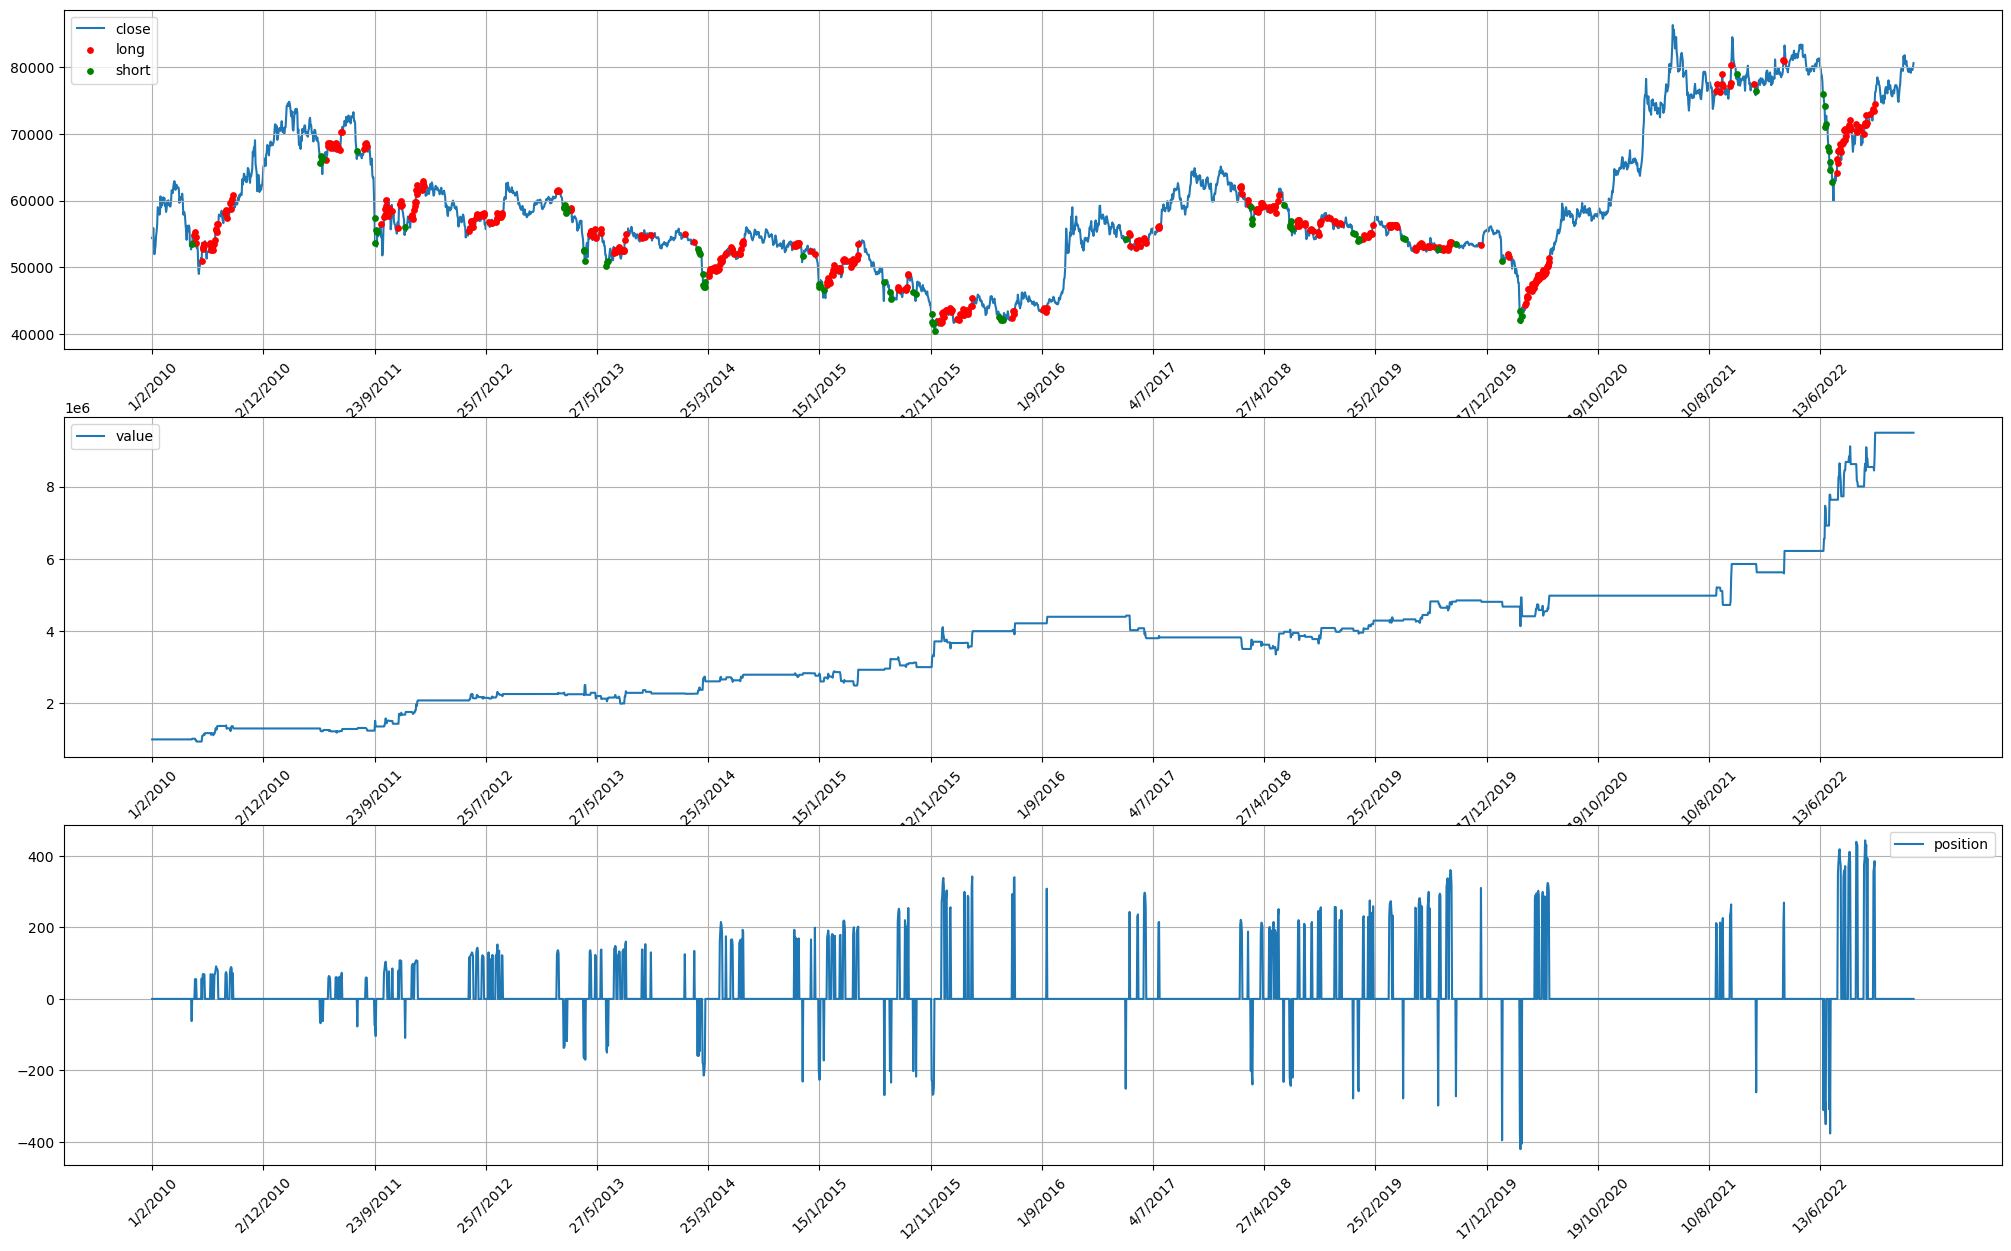

In [101]:
long_date=data[(data['long_signal']==1)]
short_date=data[(data['short_signal']==1)]
fig,ax=plt.subplots(3,1,figsize=(25,15),dpi=100)
ax[0].plot(data['date'],data['close'],label='close',zorder=1)
ax[0].grid()
ax[0].set_xticks(data['date'][::200])
ax[0].set_xticklabels(data['date'][::200],rotation=45)
ax[0].scatter(long_date['date'],long_date['close'],label='long',s=15,color='red',zorder=2)
ax[0].scatter(short_date['date'],short_date['close'],label='short',s=15,color='green',zorder=3)
ax[0].legend()
ax[1].grid()
ax[1].plot(data['date'],data['margin'],label='value')
ax[1].set_xticks(data['date'][::200])
ax[1].set_xticklabels(data['date'][::200],rotation=45)
ax[1].legend()
ax[2].grid()
ax[2].plot(data['date'],data['position'],label='position')
ax[2].set_xticks(data['date'][::200])
ax[2].set_xticklabels(data['date'][::200],rotation=45)
ax[2].legend()

plt.show()

In [104]:
(data['margin'].iloc[-1]/data['margin'].iloc[0])**(1/12)-1

0.20623973244071392

In [105]:
a=np.maximum.accumulate(data['margin'])
l=np.argmax((np.maximum.accumulate(data['margin'])-data['margin'])/np.maximum.accumulate(data['margin']))
k=np.argmax(data['margin'][:l])
print((data['margin'].iloc[k]-data['margin'].iloc[l])/data['margin'].iloc[k])

0.2428584011095221


In [106]:
test=(data['margin']-data['margin'].shift(1)) /data['margin'].shift(1)*100

In [107]:
(test>0).sum()

203

In [108]:
(test<0).sum()

186